## VQA Quiz (Total : 5점)

- 제출기한: 19/08/15
- 제출처: kwak.jinmyung@kaist.ac.kr
- 파일명: VQA Quiz_성함.ipynb 

pretrained VQA 모델, ResNet과 QA를 위한 함수들을 불러옵니다.

In [1]:
# 패키지들을 불러옵니다. 
import os, sys
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning) # Cleaner demos : Don't do this normally...
import torch
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(use_cuda)

True


In [2]:
# predefined VQA 모델을 불러옵니다.
saved_state = torch.load('./logs/2019-08-07_07_49_27.pth', map_location=device)
tokens = len(saved_state['vocab']['question']) + 1

import model
vqa_net = torch.nn.DataParallel(model.Net(tokens))
vqa_net.load_state_dict(saved_state['weights'])
vqa_net.to(device)
vqa_net.eval()

# torch.nn.DataParallel로 인해 에러가 발생할 경우
# vqa_net = torch.nn.DataParallel(model.Net(tokens)) -> vqa_net = model.Net(tokens) 수정하시고
# vqa_net = model.Net(tokens) 불러오기 전에 아래의 코드 삽입
# from collections import OrderedDict
# new_state_dict = OrderedDict()
# for k, v in saved_state['weights'].items():
#    name = k[7:] # remove `module.`
#    new_state_dict[name] = v
    
# saved_state['weights'] 대신 new_state_dict으로 대체
# vqa_net.load_state_dict(new_state_dict)      


DataParallel(
  (module): Net(
    (text): TextProcessor(
      (embedding): Embedding(15193, 300, padding_idx=0)
      (drop): Dropout(p=0.5)
      (tanh): Tanh()
      (lstm): LSTM(300, 1024)
    )
    (attention): Attention(
      (v_conv): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (q_lin): Linear(in_features=1024, out_features=512, bias=True)
      (x_conv): Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))
      (drop): Dropout(p=0.5)
      (relu): ReLU(inplace)
    )
    (classifier): Classifier(
      (drop1): Dropout(p=0.5)
      (lin1): Linear(in_features=5120, out_features=1024, bias=True)
      (relu): ReLU()
      (drop2): Dropout(p=0.5)
      (lin2): Linear(in_features=1024, out_features=3000, bias=True)
    )
  )
)

In [3]:
# image feature extraction을 위한 predefined resnet 불러옵니다. 
import resnet
import torchvision.transforms as transforms
from PIL import Image

def get_transform(target_size, central_fraction=1.0):
    return transforms.Compose([
        transforms.Resize(int(target_size / central_fraction)),
        transforms.CenterCrop(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

class ResNetLayer4(torch.nn.Module):
    def __init__(self):
        super(ResNetLayer4, self).__init__()
        self.model = resnet.resnet152(pretrained=True)
        
        image_size = 448  # scale shorter end of image to this size and centre crop
        output_features = 2048  # number of feature maps thereof
        central_fraction = 0.875 # only take this much of the centre when scaling and centre cropping

        self.transform = get_transform(image_size, central_fraction)

        def save_output(module, input, output):
            self.buffer = output
        self.model.layer4.register_forward_hook(save_output)

    def forward(self, x):
        self.model(x)
        return self.buffer
    
    def image_to_features(self, img_file):
        img = Image.open(img_file).convert('RGB')
        img_transformed = self.transform(img)
        img_batch = img_transformed.unsqueeze(0).to(device)
        return self.forward(img_batch) 
    
resnet_layer4 = ResNetLayer4().to(device)  # Downloads 241Mb model when first run


Downloading: "https://github.com/Cyanogenoid/pytorch-resnet/releases/download/hosting/resnet152-95e0e999.pth" to ./resnet152-95e0e999.pth
100%|███████████████████████████████████████████████████████████████| 241520640/241520640 [03:44<00:00, 1078102.79it/s]


In [4]:
# 단어를 고유 번호로 변환해 주는 함수 정의합니다.
# 또한 고유 번호에서 단어로 변환할 수 있는 list를 정의합니다. 

vocab = saved_state['vocab']
qtoken_to_index = vocab['question']    
QUESTION_LENGTH_MAX = 30 
    
def encode_question(question_str):
    """ Turn a question into a vector of indices and a question length """
    question_arr = question_str.lower().split(' ')
    vec = torch.zeros(len(question_arr)).long()  
    for i, token in enumerate(question_arr):
        vec[i] = qtoken_to_index.get(token, 0)
    return vec.to(device), torch.tensor( len(question_arr) ).to(device)

answer_words = ['UNDEF'] * len(vocab['answer'])
for w,idx in vocab['answer'].items():
    answer_words[idx]=w

In [7]:
# 본 퀴즈에 필요한 이미지를 다운 받습니다. 
import wget
image_urls, image_path, image_files = [
    'https://upload.wikimedia.org/wikipedia/commons/5/5a/Sunset_in_Zadar_2.jpg',
    'https://i0.wp.com/www.pasadenaweekly.com/wp-content/uploads/2018/06/wheels_web_062118.jpg',
    ], './img/', []
os.makedirs('./img', exist_ok=True)
for url in image_urls:
    image_file=os.path.join(image_path, os.path.basename(url))
    image_files.append(image_file)
    if not os.path.isfile(image_file):
        wget.download(url, out="./img/")
print(image_files)

['./img/Sunset_in_Zadar_2.jpg', './img/wheels_web_062118.jpg']


### Q1. VQA 모델의 문제점 (2점)

    VQA 모델이 오답을 도출하는 이유는 여러가지가 있으며 아래 예시는 대표적인 오답 중 하나 입니다.
    코드를 실행해 보시고 그 결과를 바탕으로 해당 예시에서 VQA 모델이 오답을 도출하는 이유를 설명해주세요.

VQA 모델의 answer distribution을 리턴하는 함수입니다.

In [8]:
def vqa_single_softmax(im_features, q_str):
    q, q_len = encode_question(q_str)
    ans, _ = vqa_net(im_features, q.unsqueeze(0), q_len.unsqueeze(0))
    ans = torch.nn.Softmax(dim=-1)(ans)
    ans = ans.squeeze()
    return ans.data.cpu()

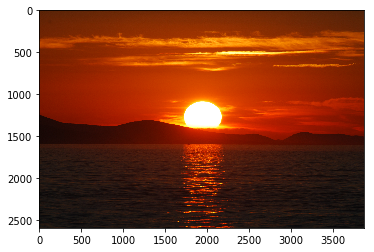

Question: is the sky blue

Top 10 answers
(1) yes : 0.55558
(2) no : 0.42958
(3) y : 0.00207
(4) maybe : 0.00179
(5) little : 0.00069
(6) somewhat : 0.00052
(7) es : 0.00051
(8) possibly : 0.00050
(9) some : 0.00044
(10) 0 : 0.00041



In [9]:
### 코드를 실행해 결과 분석 해주세요.

top = 10
image_idx = 0
question_string = "is the sky blue"
image_filename = image_files[image_idx]

img = Image.open(image_filename).convert('RGB')
plt.imshow(img)

image_features = resnet_layer4.image_to_features(image_filename)
softmax = vqa_single_softmax(image_features, question_string)
softmax_answer, answer_idx = softmax.topk(top, dim=-1)

plt.show() 
print("Question: {}".format(question_string))
print()
print("Top {} answers".format(top))
for i in range(top):
    print("({})".format(i+1),answer_words[answer_idx[i]],":", "{:.5f}".format(softmax[answer_idx[i]].item()))
print()

In [10]:
#### 답을 작성해주세요.

Answer: Open ended question-answering 데이터셋을 수집하는 과정에서 Yes/No가 대답인 방향으로 bias된 데이터셋이 만들어졌음.

### Q2. Attention Map 시각화 (3점)

    실습 때 소개한 strong baseline for VQA 모델은 attention mechanism을 적용해 이미지와 질문을 결합하는 모델입니다.
    attention map을 통해 모델이 이미지의 어떤 부분을 집중적으로 보고 정답을 유추하는지 분석할 수 있습니다.
    image_idx=1인 이미지 안에 stop sign, tree, sky로 이루어져 있습니다.
    stop sign, tree와 sky에 attention이 걸리도록 질문을 만드시고 attention map을 시각화해 주세요.

VQA 모델의 answer distribution과 attention weight을 리턴하는 함수입니다.

In [11]:
def vqa_single_softmax_attn(im_features, q_str):
    q, q_len = encode_question(q_str)
    ans, attn = vqa_net(im_features, q.unsqueeze(0), q_len.unsqueeze(0))
    ans = torch.nn.Softmax(dim=-1)(ans)
    ans = ans.squeeze()
    attn = attn.squeeze()
    return ans.data.cpu(), attn.data.cpu()

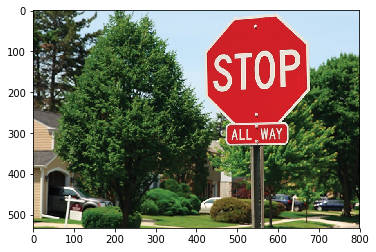

In [12]:
image_idx = 1
image_filename = image_files[image_idx]

img = Image.open(image_filename).convert('RGB')
plt.imshow(img)

attention map을 시각화 해주는 함수입니다.

In [13]:
def plot(img, attn):
    import torchvision.transforms as transforms
    # tensor -> PIL image  변환
    attn = transforms.ToPILImage()(attn) #첫번째 glimpse
    plt.imshow(img)
    plt.imshow(attn.resize(img.size, resample=1), cmap=plt.get_cmap("jet"), alpha=0.5)

(1) stop sign에 attention이 걸리도록 질문을 만드시고 plot 함수를 써서 attention map을 보여주세요 (1점)

In [73]:
top = 10

question_string = "What sign is it?"

image_features = resnet_layer4.image_to_features(image_filename)
softmax, attn = vqa_single_softmax_attn(image_features, question_string) ###  prediction과 attention weight 값을 리턴하는 함수
softmax_answer, answer_idx = softmax.topk(top, dim=-1)

print("Question: {}".format(question_string))
print()
print("Top {} answers".format(top))
for i in range(top):
    print("({})".format(i+1),answer_words[answer_idx[i]],":", "{:.5f}".format(softmax[answer_idx[i]].item()))
print()


Question: What sign is it?

Top 10 answers
(1) stop : 0.35960
(2) stop sign : 0.15759
(3) circle : 0.09010
(4) peace : 0.04044
(5) x : 0.03587
(6) round : 0.03352
(7) triangle : 0.01643
(8) street : 0.00969
(9) wave : 0.00925
(10) diamond : 0.00786



In [74]:
plt.close() # 현재 열려 있는 그림을 닫는다

In [75]:
print(attn.size())
attn = attn.view(2, 14, 14) # glimpse x height x width 
attn0 = attn[0] #첫번째 glimpse
attn1 = attn[1] #두번째 glimpse

torch.Size([2, 196])


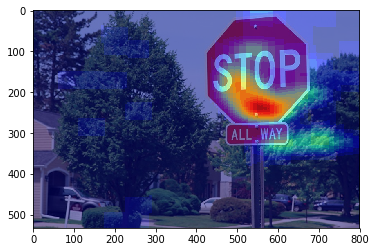

In [76]:
# 첫번째 glimpse의 attention map 시각화
plot(img, attn0)

In [77]:
plt.close() # 현재 열려 있는 그림을 닫는다

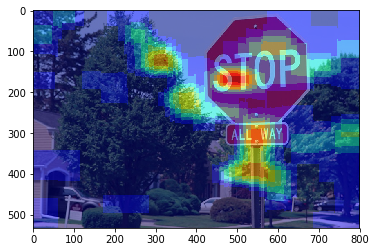

In [78]:
# 두번째 glimpse의 attention map 시각화
plot(img, attn1)

In [79]:
plt.close() # 현재 열려 있는 그림을 닫는다

(2) tree에 attention이 걸리도록 질문을 만드시고 plot 함수를 써서 attention map을 보여주세요 (1점)

In [84]:
top = 10

question_string = "What is next to the house?"

image_features = resnet_layer4.image_to_features(image_filename)
softmax, attn = vqa_single_softmax_attn(image_features, question_string)
softmax_answer, answer_idx = softmax.topk(top, dim=-1)

print("Top {} answers".format(top))
for i in range(top):
    print("({})".format(i+1),answer_words[answer_idx[i]],":", "{:.5f}".format(softmax[answer_idx[i]].item()))
print()
print("Question: {}".format(question_string))
print("Image")

Top 10 answers
(1) plant : 0.00869
(2) fire hydrant : 0.00784
(3) cat : 0.00669
(4) squirrel : 0.00623
(5) trash can : 0.00583
(6) stuffed animal : 0.00569
(7) dog : 0.00544
(8) window : 0.00480
(9) fence : 0.00476
(10) mouse : 0.00475

Question: What is next to the house?
Image


In [85]:
print(attn.size())
attn = attn.view(2, 14, 14) # glimpse x height x width 
attn0 = attn[0] #첫번째 glimpse
attn1 = attn[1] #두번째 glimpse

torch.Size([2, 196])


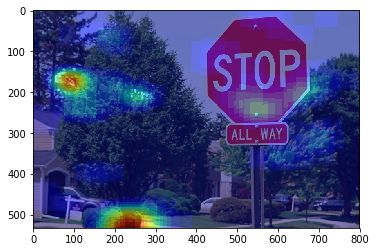

In [86]:
# 첫번째 glimpse의 attention map 시각화
plot(img, attn0)

In [87]:
plt.close() # 현재 열려 있는 그림을 닫는다

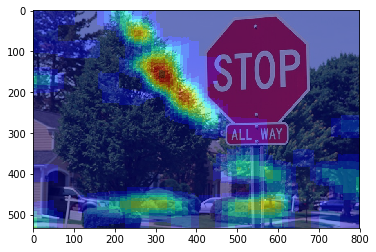

In [88]:
# 두번째 glimpse의 attention map 시각화
plot(img, attn1)

In [89]:
plt.close() # 현재 열려 있는 그림을 닫는다

(3) sky에 attention이 걸리도록 질문을 만드시고 plot 함수를 써서 attention map을 보여주세요 (1점)

In [116]:
top = 10

question_string = "How is whether today?"

image_features = resnet_layer4.image_to_features(image_filename)
softmax, attn = vqa_single_softmax_attn(image_features, question_string)
softmax_answer, answer_idx = softmax.topk(top, dim=-1)

print("Top {} answers".format(top))
for i in range(top):
    print("({})".format(i+1),answer_words[answer_idx[i]],":", "{:.5f}".format(softmax[answer_idx[i]].item()))
print()
print("Question: {}".format(question_string))
print("Image")

Top 10 answers
(1) clear : 0.21009
(2) good : 0.14042
(3) very : 0.08226
(4) nice : 0.07964
(5) cloudy : 0.05648
(6) calm : 0.04718
(7) sunny : 0.03916
(8) somewhat : 0.03899
(9) not very : 0.03516
(10) fair : 0.03491

Question: How is whether today?
Image


In [117]:
print(attn.size())
attn = attn.view(2, 14, 14) # glimpse x height x width 
attn0 = attn[0] #첫번째 glimpse
attn1 = attn[1] #두번째 glimpse

torch.Size([2, 196])


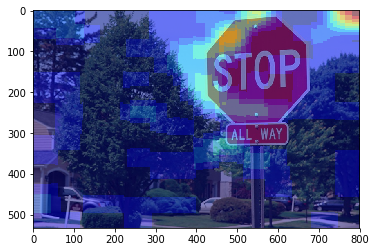

In [118]:
# 첫번째 glimpse의 attention map 시각화
plot(img, attn0)

In [119]:
plt.close() # 현재 열려 있는 그림을 닫는다

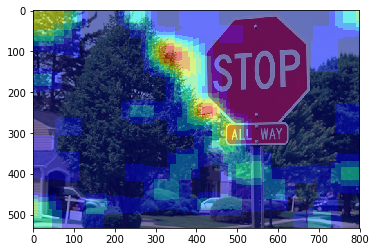

In [120]:
# 첫번째 glimpse의 attention map 시각화
plot(img, attn1)

In [121]:
plt.close() # 현재 열려 있는 그림을 닫는다